In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kazanova/sentiment140")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sentiment140


target
1    100143
0     99857
Name: count, dtype: int64


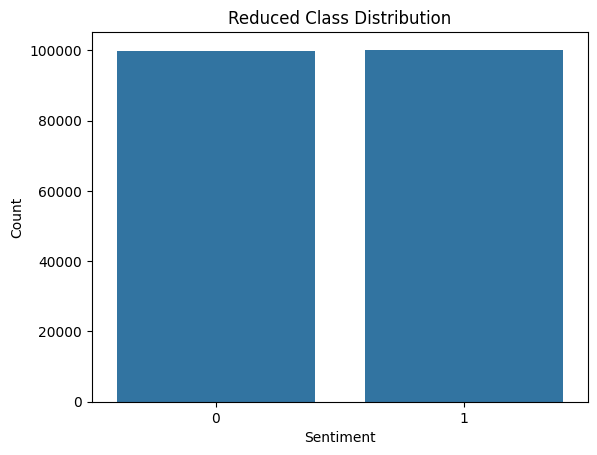

Train size: 100000, Test size: 100000


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the Sentiment140 dataset
df = pd.read_csv(f"{path}/training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

# Convert 4 (positive) to 1 and 0 (negative) stays 0
df['target'] = df['target'].apply(lambda x: 1 if x == 4 else 0)

# Reduce the dataset for faster training (~200k samples)
df = df.sample(n=200000, random_state=42)

# Show basic class distribution
print(df['target'].value_counts())

# Optional: Visualize class balance
sns.countplot(x='target', data=df)
plt.title('Reduced Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Split into train and test sets (50-50)
train_df, test_df = train_test_split(
    df,
    test_size=0.5,
    stratify=df['target'],
    random_state=42
)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizer setup
vocab_size = 10000
max_len = 30

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text'])

# Convert text to padded sequences
X_train = tokenizer.texts_to_sequences(train_df['text'])
X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')

X_test = tokenizer.texts_to_sequences(test_df['text'])
X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

# Get labels
y_train = train_df['target'].values
y_test = test_df['target'].values


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential([
    Embedding(vocab_size, 100),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=6,
    batch_size=64
)


Epoch 1/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 123s 76ms/step - accuracy: 0.7045 - loss: 0.5488 - val_accuracy: 0.7865 - val_loss: 0.4541
Epoch 2/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 130s 69ms/step - accuracy: 0.8147 - loss: 0.4091 - val_accuracy: 0.7917 - val_loss: 0.4485
Epoch 3/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 118s 75ms/step - accuracy: 0.8341 - loss: 0.3684 - val_accuracy: 0.7905 - val_loss: 0.4544
Epoch 4/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 120s 61ms/step - accuracy: 0.8578 - loss: 0.3228 - val_accuracy: 0.7912 - val_loss: 0.4673
Epoch 5/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 74ms/step - accuracy: 0.8742 - loss: 0.2861 - val_accuracy: 0.7863 - val_loss: 0.5105
Epoch 6/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 124s 63ms/step - accuracy: 0.8902 - loss: 0.2516 - val_accuracy: 0.7791 - val_loss: 0.5812


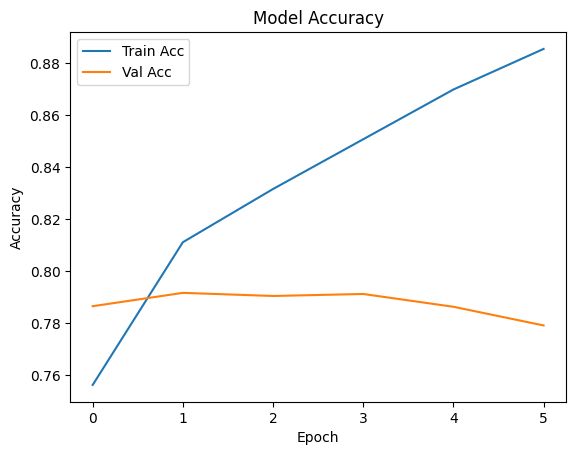

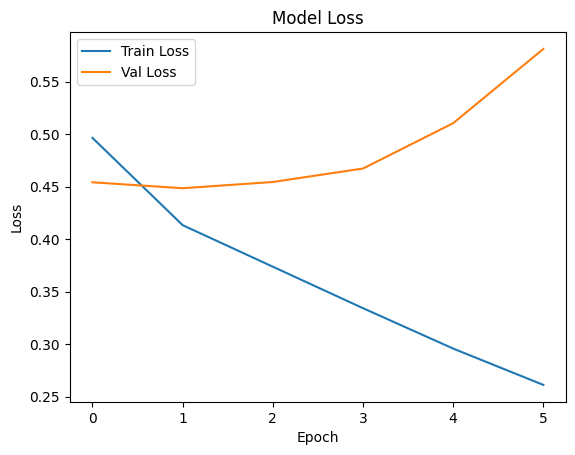

In [17]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step
Test Accuracy: 0.7791
Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.76      0.78     49929
    Positive       0.77      0.80      0.78     50071

    accuracy                           0.78    100000
   macro avg       0.78      0.78      0.78    100000
weighted avg       0.78      0.78      0.78    100000



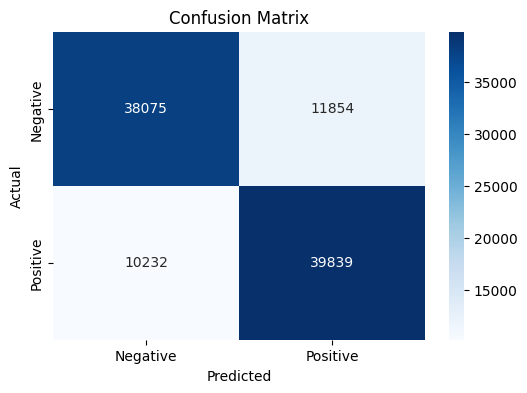

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns

# Predict on test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# Accuracy score
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [19]:
def predict_sentiment(texts):
    # Tokenize and pad
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

    # Predict
    preds = model.predict(padded)
    for i, text in enumerate(texts):
        sentiment = "Positive 😊" if preds[i] > 0.5 else "Negative 😠"
        print(f"\nInput: {text}\nPredicted Sentiment: {sentiment} (Confidence: {preds[i][0]:.2f})")

# 🔍 Example usage:
predict_sentiment([
    "I absolutely loved this product!",
    "This is the worst experience I've had.",
    "It's okay, nothing special.",
    "Fantastic job, well done!",
    "I'm not happy with the service."
])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step

Input: I absolutely loved this product!
Predicted Sentiment: Positive 😊 (Confidence: 0.99)

Input: This is the worst experience I've had.
Predicted Sentiment: Negative 😠 (Confidence: 0.11)

Input: It's okay, nothing special.
Predicted Sentiment: Negative 😠 (Confidence: 0.42)

Input: Fantastic job, well done!
Predicted Sentiment: Positive 😊 (Confidence: 1.00)

Input: I'm not happy with the service.
Predicted Sentiment: Negative 😠 (Confidence: 0.02)
